


## What kind of problem to solve?

Music Personalize Recommendation, here because of the target column is binary, we take this as a classification problem, in a nutshell, this is a binary classification.

In [31]:
%reload_ext autoreload
%autoreload 2

import os, sys, numpy as np, pandas as pd, tensorflow as tf, re, codecs, json, time, html
import pickle, collections, random, math, numbers, scipy.sparse as sp, itertools, shutil
import requests, seaborn as sns
import numba

from sklearn import preprocessing
from collections import defaultdict, Counter
from datetime import datetime
from pprint import pprint
from matplotlib import pyplot as plt
# plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid') # 

ctx = os.path.abspath(os.path.dirname('.'))
if ctx not in sys.path:
    sys.path.insert(0, ctx)

from trainer.utils import utils, utils_nb
from trainer import app_conf, metadata, input as inp, service
from trainer.ctrl import Ctrl

np.set_printoptions(precision=4, suppress=True, linewidth=100)
np.random.seed(42)

## Preview
<br/>

### train.csv
Column | Description
--:--  | --:-- 
msno | user id
song_id | song id
source_system_tab | the name of the tab where the event was triggered. System tabs are used to categorize KKBOX mobile apps functions. For example, tab my library contains functions to manipulate the local storage, and tab search contains functions relating to search.
source_screen_name | name of the layout a user sees.
source_type | an entry point a user first plays music on mobile apps. An entry point could be album, online-playlist, song .. etc.
target | this is the target variable. target=1 means there are recurring listening event(s) triggered within a month after the user’s very first observable listening event, target=0 otherwise .
<br/>

## songs.csv
Column | Description
--:--  | --:-- 
song_id | 
song_length | in ms
genre_ids | genre category. Some songs have multiple genres and they are separated by
artist_name | 
composer | 
lyricist | 
language |
<br/>

## members.csv
Column | Description
--:--  | --:-- 
msno | 
city | 
bd | age. Note: this column has outlier values, please use your judgement.
gender | 
registered_via | registration method
registration_init_time | format %Y%m%d
expiration_date | format %Y%m%d

## song_extra_info.csv
Column | Description
--:--  | --:-- 
song_id | 
song name | the name of the song.
isrc | International Standard Recording Code, theoretically can be used as an identity of a song. However, what worth to note is, ISRCs generated from providers have not been officially verified; therefore the information in ISRC, such as country code and reference year, can be misleading/incorrect. Multiple songs could share one ISRC since a single recording could be re-published several times.

In [2]:
utils.preview('./data/train.csv')

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [3]:
utils.preview('./data/test.csv')

,id,msno,song_id,source_system_tab,source_screen_name,source_type
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,NaN,song-based-playlist
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio


In [4]:
utils.preview('./data/members.csv')

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


In [5]:
utils.preview('./data/songs.csv')

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [6]:
utils.preview('./data/song_extra_info.csv')

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001


<br/>
<br/>
<br/>
## Data Clean

1. Drop `name` in `song_extra_info`

In [153]:
%%time
tr = pd.read_csv('./data/train.csv')
members = pd.read_csv('./data/members.csv')
songs = pd.read_csv('./data/songs.csv')\
          .merge(pd.read_csv('./data/song_extra_info.csv'), how='left', on='song_id')\
          .drop('name', 1)

Wall time: 34.8 s


### Interaction table

In [154]:
%%time
# source_system_tab	source_screen_name	source_type
tr['source_system_tab'] = tr.source_system_tab.fillna('')
tr['source_screen_name'] = tr.source_screen_name.fillna('')
tr['source_type'] = tr.source_type.fillna('')

Wall time: 1.21 s


### members

In [155]:
%%time
members['gender'] = members.gender.fillna('')

date_fmt = '%Y%m%d'
members['registration_init_time'] = pd.to_datetime(members.registration_init_time, format=date_fmt).map(lambda e: e.timestamp() / 86400)
members['expiration_date'] = pd.to_datetime(members.expiration_date, format=date_fmt).map(lambda e: e.timestamp() / 86400)

Wall time: 502 ms


### songs

In [156]:
%%time
def str2tuple(series):
    return series.fillna('')\
                 .map(html.unescape)\
                 .str.replace('[^.\w\|]+', ' ')\
                 .str.replace('^[\s\|]+|[\s\|]+$', '')\
                 .str.split('\s*\|+\s*')\
                 .map(lambda ary: tuple(sorted(ary)))

songs['genre_ids'] = str2tuple(songs['genre_ids'])
songs['artist_name'] = str2tuple(songs['artist_name'])
songs['composer'] = str2tuple(songs['composer'])
songs['lyricist'] = str2tuple(songs['lyricist'])
songs['language'] = songs.language.fillna(0.)

Wall time: 57.7 s


### Filter Train Data and Split Train Valid

In [157]:
msno_count = tr.groupby('msno').size()
pos_count = tr.query('target == 1').groupby('msno').size()
print(msno_count.describe(), '\n')
print(pos_count.describe())

count    30755.000000
mean       239.877028
std        314.130788
min          1.000000
25%         27.000000
50%        128.000000
75%        340.000000
max       5819.000000
dtype: float64 

count    27113.000000
mean       137.006454
std        176.338947
min          1.000000
25%         17.000000
50%         76.000000
75%        192.000000
max       3288.000000
dtype: float64


In [158]:
%%time
msno_describe = msno_count.describe()
per25, per75 = int(msno_describe['25%']), int(msno_describe['75%'])

valid_size = 0.2
def filter_fn(pipe):
    # At least 25 percentile
    if len(pipe) >= per25:
        # At most 75 percentile of latest data
        pipe = pipe[-per75:]
        len_ = len(pipe)
        is_train = np.zeros(len_)
        tr_size = int(len_ * (1 - valid_size))
        is_train[:tr_size] = 1.
        pipe['is_train'] = is_train
        return pipe

tr = tr.groupby('msno', as_index=False).apply(filter_fn)
vl = tr.query('is_train == 0').drop('is_train', 1)
tr = tr.query('is_train == 1').drop('is_train', 1)

Wall time: 21.8 s


In [159]:
%%time
# Because of performance of pandas.to_csv too slow, use this will be greate
# import csv
# def to_csv(path, df, header=True):
#     with open(path, 'w', newline='') as fp:
#         w = csv.writer(fp)
#         if header:
#             w.writerows(df.columns[None, :])
#         w.writerows(df.values)

# Write to pickle for speed
tr.to_hdf('./data/processed/cleaned/tr.h', key='df')
vl.to_hdf('./data/processed/cleaned/vl.h', key='df')

Wall time: 6.87 s


In [160]:
members.to_hdf('./data/processed/cleaned/member.h', key='df')
songs.to_hdf('./data/processed/cleaned/songs.h', key='df')

d:\python\anaconda3\envs\py3_6\lib\site-packages\pandas\core\generic.py:1471: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->['song_id', 'genre_ids', 'artist_name', 'composer', 'lyricist', 'isrc']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


<br/>
<br/>
<br/>
## Phase 1: Prepare,  Add Columns, Feature Engineering

In [161]:
%%time
members = pd.read_hdf('./data/processed/cleaned/member.h', key='df')
songs = pd.read_hdf('./data/processed/cleaned/songs.h', key='df')
tr = pd.read_hdf('./data/processed/cleaned/tr.h', key='df')
data = tr.merge(songs, how='left', on='song_id')

Wall time: 23.8 s


### members extra columns

In [162]:
%%time
msno_extra_cols = [
    'msno_age_catg', 'msno_age_num', 'msno_tenure',
    'msno_composer_hist', 'msno_composer_count', 'msno_composer_mean',
    'msno_genre_ids_hist', 'msno_genre_ids_count', 'msno_genre_ids_mean',
    'msno_language_hist', 'msno_language_count', 'msno_language_mean',
    'msno_lyricist_hist', 'msno_lyricist_count', 'msno_lyricist_mean',
    'msno_pos_query_hist', 'msno_pos_query_count', 
    'msno_neg_query_hist', 'msno_neg_query_count', 
    'msno_source_screen_name_hist', 'msno_source_screen_name_count',
    'msno_source_system_tab_hist','msno_source_system_tab_count', 
    'msno_source_type_hist', 'msno_source_type_count']

bd = members.bd.copy()
bins = np.array([6, 10, 20, 30, 40, 60, 80])
age_map = {0: '', 1: '6-10', 2: '10-20', 3: '20-30', 4: '30-40', 5: '40-60', 6: '60-80', 7: ''}
members['msno_age_catg'] = pd.Series(np.digitize(bd, bins)).map(age_map)

reasonable_range = (6 <= bd) & (bd <= 80)
median = bd[reasonable_range].describe()['50%']
bd[~reasonable_range] = median
members['msno_age_num'] = bd
members = members.drop('bd', 1)
# Tenure: the customer life time
members['msno_tenure'] = members.expiration_date - members.registration_init_time

Wall time: 157 ms


In [163]:
%%time
msno_extra = {}
base_msno = data.msno.unique()
def msno_statis(data, col, to_calc, is_multi=False):
    label_name = f'msno_{col}_hist'
    calc_names = [f'msno_{col}_{calc}' for calc in to_calc]
    if is_multi:
        msno, multi, target = utils_nb.flat(data, col)
        data = pd.DataFrame({'msno': msno, col: multi, 'target': target})
        
    series = data.groupby(['msno', col]).target.agg(to_calc).reset_index()
    def map_fn(pipe):
        ret = {label_name: tuple(sorted(pipe[col]))}
        ret.update({f'msno_{col}_{calc}': tuple(sorted(pipe[calc])) for calc in to_calc})
        return ret
    
    series = series.groupby('msno').apply(map_fn).reindex(base_msno)
    na_conds = series.isna()
    na_value = {label_name: ('',)}
    na_value.update({c: (1.,) for c in calc_names})
    series[na_conds] = [na_value] * len(na_conds)
    return extract_col(series)

def extract_col(series):
    ret = {k: [] for k in series.values[0].keys()}
    series.map(lambda dict_: [ret[k].append(v) for k, v in dict_.items()])
    return ret

# positive + negative songs query
for key in ('pos', 'neg'):
    name = f'{key}_query'
    lable_name, w_name = f'msno_{name}_hist', f'msno_{name}_count'
    query = data.query(f"target == {1 if key == 'pos' else 0}")\
                .groupby('msno')\
                .apply(lambda e: {lable_name: tuple(e.song_id), w_name: (1.,) * len(e)})\
                .reindex(base_msno)
    na_conds = query.isna()
    query[na_conds] = [{lable_name: ('',), w_name: (1.,)}] * len(na_conds)
    msno_extra.update(extract_col(query))
    
# Freq distribution of each member interaction with context
for col in ('source_system_tab', 'source_screen_name', 'source_type'):
    msno_extra.update( msno_statis(data, col, ['count']) )

# Preference of each member, calculate freq and mean
msno_extra.update( msno_statis(data, 'language', ['count', 'mean']))
for col in ('composer', 'genre_ids', 'composer', 'lyricist'):
    msno_extra.update(msno_statis(data, col, ['count', 'mean'], is_multi=True))
    
msno_extra = pd.DataFrame(msno_extra)
msno_extra['msno'] = base_msno
members = members.merge(msno_extra, how='left', on='msno')

Wall time: 1min 53s


In [164]:
%%time
members.to_hdf('./data/processed/prepared/member.h', key='df')

d:\python\anaconda3\envs\py3_6\lib\site-packages\pandas\core\generic.py:1471: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['msno', 'gender', 'msno_age_catg', 'msno_composer_count', 'msno_composer_hist', 'msno_composer_mean', 'msno_genre_ids_count', 'msno_genre_ids_hist', 'msno_genre_ids_mean', 'msno_language_count', 'msno_language_hist', 'msno_language_mean', 'msno_lyricist_count', 'msno_lyricist_hist', 'msno_lyricist_mean', 'msno_neg_query_count', 'msno_neg_query_hist', 'msno_pos_query_count', 'msno_pos_query_hist', 'msno_source_screen_name_count', 'msno_source_screen_name_hist', 'msno_source_system_tab_count', 'msno_source_system_tab_hist', 'msno_source_type_count', 'msno_source_type_hist']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


Wall time: 5.03 s


### songs extra columns

In [142]:
# songs = pd.read_hdf('./data/processed/cleaned/songs.h')
# tr = pd.read_hdf('./data/processed/cleaned/tr.h')

In [165]:
# members = pd.read_hdf('./data/processed/prepared/member.h')
data = tr.merge(members,  how='left', on='msno')

In [166]:
%%time
song_extra_cols = [
    'song_cc', 'song_xxx', 'song_yy', 'song_clicks', 'song_pplrty', 
    'song_artist_name_len', 'song_composer_len', 'song_lyricist_len', 'song_genre_ids_len',
    'song_source_system_tab_hist', 'song_source_system_tab_count',
    'song_source_screen_name_hist', 'song_source_screen_name_count',
    'song_source_type_hist', 'song_source_type_count',
    'song_msno_age_catg_hist', 'song_msno_age_catg_count', 'song_msno_age_catg_mean',
    'song_gender_hist', 'song_msno_gender_count', 'song_msno_gender_mean',
    'song_registered_via_hist', 'song_registered_via_count', 'song_registered_via_mean',
    'song_city_hist', 'song_city_weights'
]

# Decode isrc
songs['song_cc'] = songs.isrc.str.slice(0, 2).fillna('')
songs['song_xxx'] = songs.isrc.str.slice(2, 5).fillna('')

songs['song_yy'] = songs.isrc.str.slice(5, 7)\
                        .map(lambda e: 2000 + int(e) if int(e) < 18 else 1900 + int(e), na_action='ignore')
songs['song_yy'] = songs.song_yy.fillna(songs.song_yy.median())
songs['song_yy'] = songs.song_yy - 1900

songs['song_artist_name_len'] = songs.artist_name.map(len)
songs['song_composer_len'] = songs.composer.map(len)
songs['song_lyricist_len'] = songs.lyricist.map(len)
songs['song_genre_ids_len'] = songs.genre_ids.map(len)

songs.drop('isrc', 1, inplace=True)

Wall time: 12.3 s


In [167]:
%%time
def song_statis(data, col, to_calc, is_multi=False):
    s = datetime.now()
    label_name = f'song_{col}_hist'
    calc_names = [f'song_{col}_{calc}' for calc in to_calc]
    if is_multi:
        song, multi, target = utils_nb.flat(data, col)
        data = pd.DataFrame({'song': song, col: multi, 'target': target})
    series = data.groupby(['song_id', col]).target.agg(to_calc).reset_index()
    
    def map_fn(pipe):
        ret = {label_name: tuple(sorted(pipe[col]))}
        ret.update({f'song_{col}_{calc}': tuple(sorted(pipe[calc])) for calc in to_calc})
        return ret
    series = series.groupby('song_id').apply(map_fn).reindex(base_song)
    
    na_conds = series.isna()
    na_value = {label_name: ('',)}
    na_value.update({c: (1.,) for c in calc_names})
    series[na_conds] = [na_value] * len(na_conds)
    ret = extract_col(series)
    print(f'{col} {",".join(to_calc)} done, take {datetime.now() - s}')
    return ret


basic_stats = data.groupby('song_id').target.agg(['count', 'mean'])
basic_stats['song_clicks'] = basic_stats['count']
basic_stats['song_pplrty'] = basic_stats['mean']
basic_stats.drop(['count', 'mean'], 1, inplace=True)
print(f'song_clicks done.')
print(f'song_pplrty done.')
'''
'registration_init_time', 'expiration_date', 'msno_tenure',
'''
songs_extra = {}
base_song = data.song_id.unique()
# Freq distribution of each song interaction with context
for col in ('source_system_tab', 'source_screen_name', 'source_type', 'registered_via'):
    songs_extra.update( song_statis(data, col, ['count']) )

# Preference of each song, calculate freq and mean
for col in ('city', 'gender', 'msno_age_catg'):
    songs_extra.update( song_statis(data, col, ['count', 'mean']) )
    
songs_extra = pd.DataFrame(songs_extra)
songs_extra['song_id'] = base_song
songs = songs.merge(songs_extra, how='left', on='song_id')

song_clicks done.
song_pplrty done.
source_system_tab count done.
source_screen_name count done.
source_type count done.
registered_via count done.
city count,mean done.
gender count,mean done.
msno_age_catg count,mean done.
Wall time: 4min 49s


In [168]:
%%time
songs.to_hdf('./data/processed/prepared/songs.h', key='df')

d:\python\anaconda3\envs\py3_6\lib\site-packages\pandas\core\generic.py:1471: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['song_id', 'genre_ids', 'artist_name', 'composer', 'lyricist', 'song_cc', 'song_xxx', 'song_city_count', 'song_city_hist', 'song_city_mean', 'song_gender_count', 'song_gender_hist', 'song_gender_mean', 'song_msno_age_catg_count', 'song_msno_age_catg_hist', 'song_msno_age_catg_mean', 'song_registered_via_count', 'song_registered_via_hist', 'song_source_screen_name_count', 'song_source_screen_name_hist', 'song_source_system_tab_count', 'song_source_system_tab_hist', 'song_source_type_count', 'song_source_type_hist']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


Wall time: 27.5 s


In [169]:
# Write to hdf for speed
tr.to_hdf('./data/processed/prepared/tr.h', key='df')
vl.to_hdf('./data/processed/prepared/vl.h', key='df')

## Phase2: Fit

### load latest persistent data

In [7]:
%%time
members = pd.read_hdf('./data/processed/prepared/member.h', key='df')
songs = pd.read_hdf('./data/processed/prepared/songs.h', key='df')
tr = pd.read_hdf('./data/processed/prepared/tr.h', key='df')
vl = pd.read_hdf('./data/processed/prepared/vl.h', key='df')
data = tr.merge(members, how='left', on='msno').merge(songs, how='left', on='song_id')

Wall time: 1min 25s


In [12]:
data.columns, data.columns.shape

(Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
        'source_type', 'target', 'city', 'gender', 'registered_via',
        'registration_init_time', 'expiration_date', 'msno_age_catg',
        'msno_age_num', 'msno_tenure', 'msno_composer_count',
        'msno_composer_hist', 'msno_composer_mean', 'msno_genre_ids_count',
        'msno_genre_ids_hist', 'msno_genre_ids_mean', 'msno_language_count',
        'msno_language_hist', 'msno_language_mean', 'msno_lyricist_count',
        'msno_lyricist_hist', 'msno_lyricist_mean', 'msno_neg_query_count',
        'msno_neg_query_hist', 'msno_pos_query_count', 'msno_pos_query_hist',
        'msno_source_screen_name_count', 'msno_source_screen_name_hist',
        'msno_source_system_tab_count', 'msno_source_system_tab_hist',
        'msno_source_type_count', 'msno_source_type_hist', 'song_length',
        'genre_ids', 'artist_name', 'composer', 'lyricist', 'language',
        'song_cc', 'song_xxx', 'song_yy', 'song_artist_na

In [40]:
%%time
sep_fn = lambda e: e

HEADER = [
    # User features
    'msno', 
    'city', 'gender', 'registered_via',
    'registration_init_time', 'expiration_date', 'msno_age_catg', 'msno_age_num', 'msno_tenure', 
    'msno_composer_hist', 'msno_composer_mean', 'msno_composer_count',
    'msno_genre_ids_hist', 'msno_genre_ids_mean', 'msno_genre_ids_count',
    'msno_language_hist', 'msno_language_mean', 'msno_language_count',
    'msno_lyricist_hist', 'msno_lyricist_mean', 'msno_lyricist_count',
    'msno_pos_query_hist', 'msno_pos_query_count', 
    'msno_neg_query_hist', 'msno_neg_query_count',
    'msno_source_screen_name_hist', 'msno_source_screen_name_count', 
    'msno_source_system_tab_hist', 'msno_source_system_tab_count', 
    'msno_source_type_hist', 'msno_source_type_count', 
    # Song features
    'song_id', 
    'genre_ids', 'artist_name', 'composer', 'lyricist', 'language', 'song_cc', 'song_xxx', 'song_yy', 'song_length',
    'song_artist_name_len', 'song_composer_len', 'song_lyricist_len', 'song_genre_ids_len',
    'song_city_hist', 'song_city_count', 'song_city_mean',
    'song_gender_hist', 'song_gender_count', 'song_gender_mean',
    'song_msno_age_catg_hist', 'song_msno_age_catg_count', 'song_msno_age_catg_mean', 
    'song_registered_via_hist', 'song_registered_via_count',
    'song_source_screen_name_hist', 'song_source_screen_name_count', 
    'song_source_system_tab_hist', 'song_source_system_tab_count',  
    'song_source_type_hist', 'song_source_type_count',
    # Context features
    'source_system_tab', 'source_screen_name', 'source_type', 
    # Label
    'target'
]
TARGET_NAME = 'sales'

mapper_dict = {}

# Categorical univariate features
for uni_catg in ('source_system_tab', 'source_screen_name', 'source_type', 'city',
            'gender', 'registered_via', 'msno_age_catg', 'language', 'song_cc', 'song_xxx'):
    mapper_dict[uni_catg] = utils.CatgMapper().fit( data[uni_catg] )

# Categorical multivariate features
    # 'msno_composer_hist', 'msno_genre_ids_hist', 'msno_language_hist',  'msno_lyricist_hist', 
    # 'msno_pos_query_hist', 'msno_neg_query_hist', 'msno_source_screen_name_hist', 'msno_source_system_tab_hist', 'msno_source_type_hist', 
    # 'song_city_hist', 'song_gender_hist', 'song_msno_age_catg_hist', 'song_registered_via_hist', 'song_source_screen_name_hist', 
    # 'song_source_system_tab_hist', 'song_source_type_hist'
for multi_catg in ('genre_ids', 'artist_name', 'composer', 'lyricist'):
    mapper_dict[multi_catg] = utils.CatgMapper(is_multi=True, sep=sep_fn).fit( data[multi_catg] )
    pass
    
# Numeric features
for numeric in ('registration_init_time', 'expiration_date', 'msno_age_num', 'msno_tenure', 'song_yy',
            'song_length'):
    mapper_dict[numeric] = utils.NumericMapper(scaler=preprocessing.StandardScaler()).fit( data[numeric] )

d:\python\anaconda3\envs\py3_6\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Wall time: 13 s


In [38]:
data_copy = pd.DataFrame()
for feat in ('source_system_tab', 'source_screen_name', 'source_type', 'city',
        'gender', 'registered_via', 'msno_age_catg', 'language', 'song_cc', 'song_xxx',
        'registration_init_time', 'expiration_date', 'msno_age_num', 'msno_tenure', 'song_yy',
        'song_length'):
    data_copy[feat] = utils.transform(data[feat], mapper_dict[feat])

# for feat in ('msno_composer_hist', 'msno_genre_ids_hist', 'msno_language_hist',  'msno_lyricist_hist', 
#         'msno_pos_query_hist', 'msno_neg_query_hist', 'msno_source_screen_name_hist', 'msno_source_system_tab_hist', 'msno_source_type_hist', 
#         'song_city_hist', 'song_gender_hist', 'song_msno_age_catg_hist', 'song_registered_via_hist', 'song_source_screen_name_hist', 
#         'song_source_system_tab_hist', 'song_source_type_hist'):
#     data[feat] = utils.transform(data[feat], mapper_dict[feat], is_multi=True, sep=lambda e: e)

init logger instance ...
init logger instance ...
init logger instance ...


KeyError: 'registration_init_time'

In [67]:
def map_fn(pipe):
    pipe['genre_ids'] = tf.string_split([pipe['genre_ids']], delimiter='|').values
    return pipe

with tf.Graph().as_default():
    # ds = tf.data.Dataset.from_tensor_slices({'col1': [1, 2, 3], 'col2': [(1, 2), (0, 0), (0, 0)]})
    ds = tf.data.Dataset.from_tensor_slices(a.head(30)[['genre_ids', 'target']].to_dict('list'))
    ds = ds.map(map_fn)
    ds = ds.make_one_shot_iterator().get_next()
    # ds = tf.data.Dataset.from_generator(
    #     gen_fn, (tf.int32, tf.int32), (tf.TensorShape([None]), tf.TensorShape([]))
    # )
    with tf.Session() as sess:
        print( sess.run(ds) )
        pass

TypeError: Failed to convert object of type <class 'list'> to Tensor. Contents: ['359', '1259', '1259', '1019', '1011', '1259', '465', '1011', '2022', '465', '465', '465', '465', '458', '465|458', '465', '465', '458', '465', '465', '458', '465', '465', '2022', '2022', '2022', '465', '465', '465', nan]. Consider casting elements to a supported type.

In [40]:
df = pd.DataFrame({'composer_list': data.composer_list.dropna().values, 
                   'len': data.composer_list.dropna().map(len).values})
print(df.head())
df.loc[df.len.idxmax()].composer_list

                               composer_list  len
0                     (Dan Smith, Mark Crew)    2
1    (N. Jones、W. Adams、J. Lordan、D. Ingle,)    1
2                           (Kwadwo Donkoh,)    1
3  (Brett Young, Justin Ebach, Kelly Archer)    3
4                 (Adnan Khan, Sidney Selby)    2


('1011,Kenny Rogers,Roger Bowling',
 '139,G.E.M.鄧紫棋,Kaci Brown',
 '139,Oldies 101,William Mickey Stevenson',
 '947,Music-Themes,,,-1\nXPGjUo/wPuYRoFYVB25kQ9TX5zP6Izcllmez7PPXB4I=,241673,465,Janet Jackson,Janet Jackson',
 'Aaron Gillespie',
 'Brian Carroll,,52\n0KjXAae7rj9kfrIGhAoYBWJoQBqjtzTQMKMprbnStrs=,229506,,Monday Kiz,,,31\nvoMgKcLbhYr1GIsEuMvT+Rjkib1qvY4WPSmw/mc8j1c=,402703,940,Guy Sweens,,,-1\nPy+ROjXqGeJtSyQu1GWUEdvOkbEoKmBowX9lCq+E1Ow=,203593,1259,Pigeon John,,,52\n8jxho4ldBqaadnEiNjhgF8keOFBc4z6Gy6zTMKvw7Tg=,245856,465,Bertie Higgins,Bertie Higgins/Sonny Limbo,Bertie Higgins/Sonny Limbo,52\nImz3KL8KDLWIvNu/ytrFODhUvNCfziDLNdQP3OBIH/c=,347834,726,Hillsong Kids Junior,,,-1\nmRh2QjHNk3tcjKszLXpnCWUgREMRk6H4RDOdCn48T8w=,249568,465,Melanie C,Rick Nowels',
 'Charles Twong',
 'Chauncey Hollis,,52\n9sYIx+29PAF7BOk4loE2xYPSdeg7zmpGwbbInOyVhVo=,172849,921,Randy Newman,Axwell',
 'Christopher Dudley,,52\nOi7rlCO6VbZZ5UqcSyg8vDVvFjMQYeV+iYAbxB6LSd0=,169227,2122,Sarah Vaughan,R. Turk',
 'D

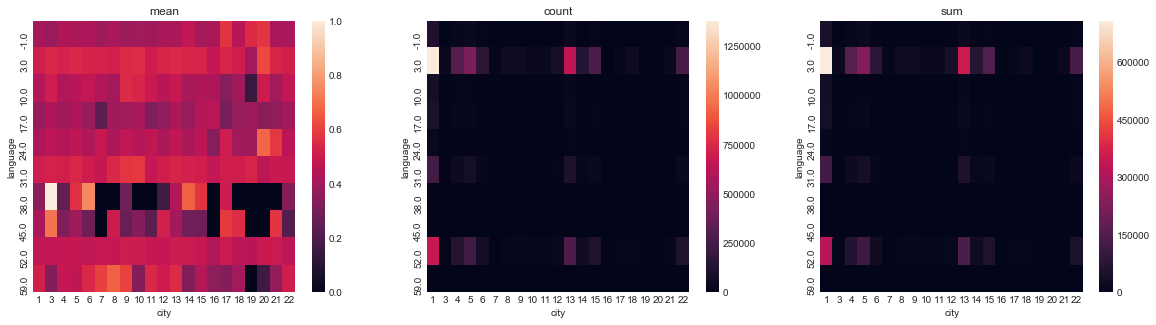

In [13]:
utils_nb.heatmap(data, 'language', 'city', annot=False)

## Age and Genres

In [ ]:
%%time
multi_catg_heatmap('genre_list', 'age')

## Popular Artist
-  We evaluate the popularity of the artist by calculate `mean * sum` by target label, value of target belong to [0, 1], so `sum` can represent the popularity but, maybe there are many 0 in the votes, so multiple the `mean` to get more fair result
-  According the boxplot, the popularity distribution is very skew, most of them close to zero, this is expected result, for this situation, we will add some features like the interaction between `[target + artist], [target + language]`..., etc.

In [ ]:
artist_list, target = flat('artist_list')
univ_boxplot(pd.DataFrame({'artist_list': artist_list, 'target': target}), 'artist_list')

In [ ]:
artist_list, target = flat('artist_list')
univ_boxplot(pd.DataFrame({'artist_list': artist_list, 'target': target}), 'artist_list')

<br/>
<br/>
<br/>
## Filter some rows

1. First we filter out the majority and the minority => [100 <= msno.group.size <= 1000], we don't want some majority to dominate the model
2. Insure that records of target = 1 greater than 35, we want 30% in valid data records of target = 1 greater than 10
    ```
    35 * 0.3 = 10.5
    ```

In [ ]:
""" Use DataFrameGroupBy.filter will be greate !!!"""
# msno_grp = data.groupby('msno')
# msno_grp.size().describe()

# df = pd.DataFrame({'size': msno_grp.size(), 'sum': msno_grp.target.sum()})

# data = data[data.msno.isin(df.query('sum >= 35 and 100 <= size and size <= 1000').index)]
# print(data.shape)
# print(data.target.value_counts())

In [ ]:
enc = utils.CounterEncoder()
enc.partial_fit( train.source_system_tab )

In [ ]:
np.linalg.norm([1, 2, 3] / np.linalg.norm([1, 2, 3]))


In [ ]:
feat = 'source_system_tab'
feat_dummies = pd.get_dummies(data[feat])
feat_dummies.columns = ['msno_%s_'%feat + '%s'%col for col in feat_dummies.columns]
feat_dummies.head()
feat_dummies['msno'] = data['msno'].values
feat_dummies = feat_dummies.groupby('msno').mean()
feat_dummies['msno'] = feat_dummies.index
a = members.merge(feat_dummies, on='msno', how='left')
a.head()

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
## Appendix

+ Use `tf.saved_model.loader.load`, only for `json_serving_input_fn `

In [ ]:
%%time
from trainer import app_conf, metadata, input, service
from trainer.ctrl import Ctrl

ctrl = Ctrl.instance
test_df = ctrl.transform(pd.Series({'fpath': './data/test.csv'}))
params = pd.Series({
    'datasource': test_df,
    'is_src_file': False
})
pred = ctrl.local_predict_alt(params)
print(pred)

## Tensor data inspection

In [ ]:
%%time
from trainer import app_conf, metadata, input, service
from trainer.ctrl import Ctrl

encoded, origin, feat_data, target_, all_ = Ctrl.instance.inspect('promo2')

## Test

In [56]:
from trainer import app_conf, metadata, input, service
from trainer.ctrl import Ctrl

with tf.Graph().as_default():
    norm = tf.norm(tf.constant([1., 2., 3.]), ord='euclidean')
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        print( sess.run(norm) )

3.7416575
